In this notebook diffrent parameters are tested, inorder to find a optimal choice of parameters for an LSTM network with respect to validation preformence. The traing data contains samples form skier 1, and 3, wheresd the validation is done on skier 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [5]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [6]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [7]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [8]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [9]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(445, 140, 22)
(372, 140, 18)
(854, 140, 22)
(445, 4)
(372, 4)
(854, 4)


In [10]:
dim_X = len(feature_Dict)
time_step = 140
nbr_of_classes = 4
X = np.concatenate((X_First, X_Third), axis=0)[:,:,:dim_X]
Y= np.concatenate((Y_First, Y_Third), axis=0)
X_Test = X_Second[:,:,:dim_X]
Y_Test = Y_Second

In [9]:
print(X.shape)
print(Y.shape)
print(X_Test.shape)
print(Y_Test.shape)

(1299, 140, 17)
(1299, 4)
(372, 140, 17)
(372, 4)


In [10]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [11]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [12]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [13]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)

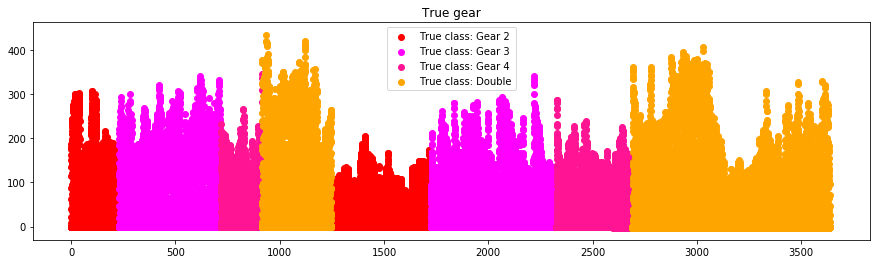

In [14]:
true_Y = np.argmax(Y,axis = 1)
figure = plot_skiedata(true_Y,X,0)

In [11]:
def LSTM_Two_Dense_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(26,return_sequences=True)(sequence_input)
    print(x.shape)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
def LSTM_Two_Dense_126_Drop_05():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True, recurrent_dropout = 0.5)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [44]:
model = LSTM_Two_Dense_126_Drop_05()
history  = model.fit(X[:,:,1:], Y, epochs=6, batch_size=1,shuffle = True,validation_split = 0.1)

Train on 1169 samples, validate on 130 samples
Epoch 1/6
1169/1169 [==============================] - 270s 231ms/step - loss: 0.3929 - acc: 0.8529 - val_loss: 0.1203 - val_acc: 0.9846
Epoch 2/6
1169/1169 [==============================] - 265s 227ms/step - loss: 0.1131 - acc: 0.9641 - val_loss: 0.1945 - val_acc: 0.9615
Epoch 3/6
1169/1169 [==============================] - 268s 229ms/step - loss: 0.0577 - acc: 0.9837 - val_loss: 0.1263 - val_acc: 0.9769
Epoch 4/6
1169/1169 [==============================] - 269s 230ms/step - loss: 0.0328 - acc: 0.9949 - val_loss: 0.1166 - val_acc: 0.9846
Epoch 5/6
1169/1169 [==============================] - 267s 229ms/step - loss: 0.0273 - acc: 0.9932 - val_loss: 0.1079 - val_acc: 0.9923
Epoch 6/6
1169/1169 [==============================] - 263s 225ms/step - loss: 0.0158 - acc: 0.9957 - val_loss: 0.1250 - val_acc: 0.9923


In [46]:
from keras.models import load_model
model.save('LSTM_1_3_New_Preprocess_05.h5')

In [47]:
from keras.models import load_model
model = load_model('LSTM_1_3_New_Preprocess_05.h5')
predY = model.predict(X_Test[:,:,1:dim_X])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(372, 4)
Accuracy: 0.78


In [12]:
model = LSTM_Two_Dense_126_Drop_05()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 140, 126)          72072     
_________________________________________________________________
dense_1 (Dense)              (None, 140, 140)          17780     
_________________________________________________________________
flatten_1 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 78404     
Total params: 168,256
Trainable params: 168,256
Non-trainable params: 0
_________________________________________________________________
